In [36]:
import h5py
import numpy as np
import spimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

In [2]:
run = 49
filename = './data/r%04d.h5' %(run)

In [3]:
with h5py.File(filename, 'r') as f:
    data = np.float64(f['diff_pat'][:])

In [4]:
with h5py.File('mask.h5', 'r') as f:
    mask_init = f['data'][:]

In [33]:
# Experimental parameters
downsampling = 4
pixelsize = downsampling * 75e-6
distance = 0.315 # From logbook
material = 'virus'
phenergy = 1240. #eV
wavelength = (1239.8418746 / phenergy) * 1e-9 # m
saturation_level = 10000
sh = data.shape[1:]
gain = 360 # ADUs per photn

In [6]:
# Centering parameters
centering_maxshift  = 40 / downsampling
centering_threshold = 0.5
centering_blur      = 4
centering_x0 = sh[1]/2.
centering_y0 = sh[0]/2.

In [7]:
# Sizing parameters
diameter_start  = 35 * 1e-9
intensity_start = 1. * 1e-3 / 1e-12 #[mJ/um2]
brute_evals = 200
rmax = 450 / downsampling
maskradius = 150 / downsampling

In [8]:
# Spherical mask
def rmask(r, sh, cx, cy):
    ny, nx = sh
    xx,yy = np.meshgrid(np.arange(nx), np.arange(ny))
    return (xx-cx)**2 + (yy-cy)**2 > (r**2)

## Sizing

In [9]:
index = 13

### Pre-processing

In [10]:
# Include saturated pixels in the mask
adudata = data[index]
mask_saturated = (adudata < saturation_level)
mask_init &= mask_saturated

# Remove background
adudata[adudata <= centering_threshold*gain] = 0.
# Divide by gain
photondata = adudata / gain
# Downsample the data
data_ds, mask_ds = spimage.binImage(photondata, downsampling, msk=mask_init, output_binned_mask=True)
# Counting photons
photons = np.round(data_ds)
mask = mask_ds.astype(np.bool)

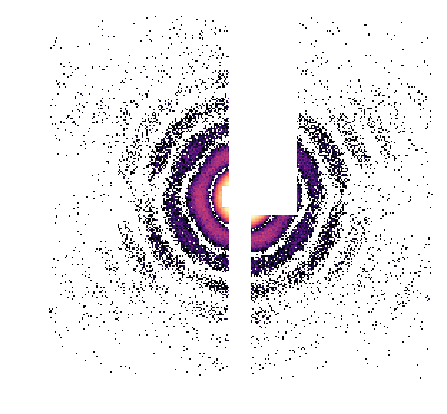

In [11]:
plt.figure(figsize=(5,5), dpi=100)
plt.axis('off')
plt.imshow(photons*mask, norm=colors.LogNorm(), cmap='magma')
plt.show()

### Step 1. Finding the center

In [12]:
x,y = spimage.find_center(photons,mask,method='blurred', 
                          x0=centering_x0, y0=centering_y0,dmax=centering_maxshift, 
                          threshold=centering_threshold, blur_radius=centering_blur)
print("Step 1: Found center position (%.2f, %2.f)" %(x,y))

Step 1: Found center position (3.00,  0)


In [13]:
# Add spherical mask in the center (restricting the sizing to low q)
mask_sizing = mask & ~rmask(maskradius, mask.shape, mask.shape[1]/2+x, mask.shape[0]/2+y)

### Step 2. Finding the size

In [25]:
diameter, info = spimage.fit_sphere_diameter(photons, mask_sizing, diameter_start, intensity_start, 
                                             wavelength, pixelsize, distance,
                                             method='pearson', full_output=True, x0=x, y0=y, 
                                             detector_adu_photon=1., detector_quantum_efficiency=1., 
                                             material=material, rmax=rmax, downsampling=1, 
                                             do_brute_evals=brute_evals, do_photon_counting=False, 
                                             maxfev=50000, brute_dmax=200e-9)

In [26]:
print("Step 2: Found diameter of %.2f nm" %(diameter*1e9))
print("Chisquared/Norm. Mean Error: %.3g/%.3g" %(info["chisquared"], info['error']))

Step 2: Found diameter of 60.56 nm
Chisquared/Norm. Mean Error: 6.77e-09/6.51e-12


### Step 3. Finding the intensity

In [27]:
intensity, info = spimage.fit_sphere_intensity(photons, mask_sizing, diameter, intensity_start, 
                                               wavelength, pixelsize, distance, 
                                               method='nrphotons', full_output=True, x0=x, y0=y, 
                                               detector_adu_photon=1., detector_quantum_efficiency=1., 
                                               material=material, rmax=rmax, downsampling=1, do_photon_counting=True)
print("Step 3: Found intensity of %.4f mJ/um2" %(intensity / (1e-3 / 1e-12)))
print("Chisquared/Norm. Mean Error: %.3g/%.3g" %(info["chisquared"], info['error']))

Step 3: Found intensity of 0.0185 mJ/um2
Chisquared/Norm. Mean Error: 0/0


### Step 4. Full optimization (center, size, intensity)

In [28]:
x, y, diameter, intensity, info = spimage.fit_full_sphere_model(photons, mask_sizing, diameter, intensity,
                                                                wavelength, pixelsize, distance, 
                                                                full_output=True, x0=x, y0=y, 
                                                                detector_adu_photon=1., detector_quantum_efficiency=1., 
                                                                material=material, rmax=rmax, 
                                                                downsampling=1, do_photon_counting=True, deltab=0.5, n=1)
print("Step 4: Full optimization (x=%.2f, y=%.3f, d=%.3f nm, i=%.4f mJ/um2)" %(x,y, diameter*1e9, intensity / (1e-3 / 1e-12)))
print("Chisquared/Norm. Mean Error: %.3g/%.3g" %(info["chisquared"], info['error']))

Step 4: Full optimization (x=3.56, y=0.427, d=60.497 nm, i=0.0172 mJ/um2)
Chisquared/Norm. Mean Error: 3.19/3.53e-06


### Summary

In [66]:
# Detector sampling
Y,X = spimage.grid(photons.shape, (0,0))
Xc = spimage.x_to_qx(X - x,pixelsize,distance)
Yc = spimage.y_to_qy(Y - y,pixelsize,distance)
q = np.sqrt(Xc**2 + Yc**2)
qr = spimage.x_to_qx(np.arange(0,photons.shape[0]/2.), pixelsize/downsampling, distance)

In [67]:
# Radial average
centers, photons_r = spimage.radialMeanImage(photons, msk=mask, 
                                             cx=photons.shape[1]/2+x, cy=photons.shape[0]/2+y, output_r=True)
photons_qr = spimage.x_to_qx(centers, pixelsize, distance)[:photons.shape[0]//2]
photons_r  = photons_r[:photons.shape[0]//2]

In [68]:
# Fitted diffraction pattern
A = spimage.sphere_model_convert_intensity_to_scaling(intensity, diameter, wavelength, pixelsize, 
                                                      distance, material=material)
s = spimage.sphere_model_convert_diameter_to_size(diameter, wavelength, pixelsize, distance)
fit_2d = np.random.poisson(spimage.I_sphere_diffraction(A,q,s)).astype(np.float64)
fit_1d = spimage.I_sphere_diffraction(A,qr,s)

In [78]:
# customized colors
cmap = cm.get_cmap('magma')
cmap.set_bad('green')
cmap.set_under('black')

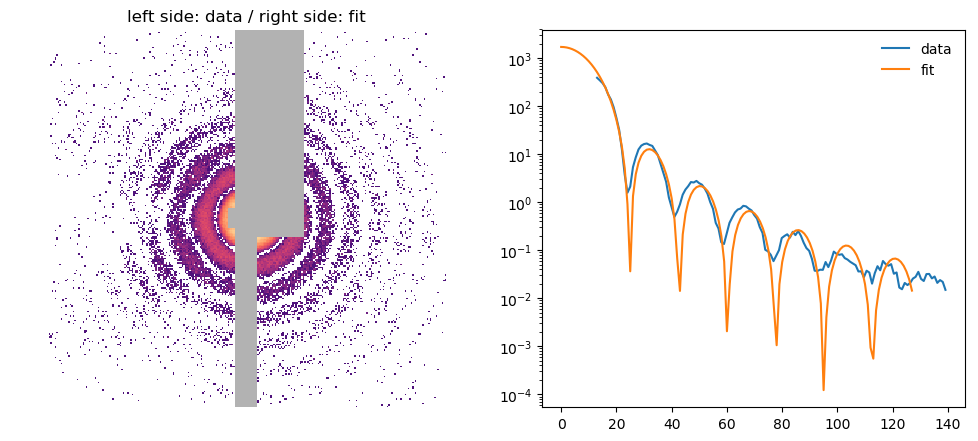

In [77]:
img = np.copy(photons)
img[:,photons.shape[1]//2:] = fit_2d[:,photons.shape[1]//2:]
img[img == 0] = 1e-10
img[~mask] = np.nan
cmap.set_bad('0.7')
cmap.set_under('white')
fig, axes = plt.subplots(ncols=2, figsize=(12,5), dpi=100)
axes[0].axis('off')
axes[0].set_title('left side: data / right side: fit')
axes[0].imshow(img*mask, norm=colors.LogNorm(vmin=0.1, vmax=1000), cmap=cmap)
axes[1].plot(photons_qr, photons_r, label='data')
axes[1].plot(qr, fit_1d, label='fit')
axes[1].semilogy()
axes[1].legend(frameon=False)
plt.show()